## The trick to calculate f_mu and f_sigma is to feed data into a NN to compute some hidden features (low dimensional space) then we use t and the hidden features to feed a tiny NN[t] to calculate the functions for each timestep. this is done to reduce the number of parameters.

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from helpers import sample_batch

### Explanation:
In the context of diffusion models, we structure the neural network to predict two values at each reverse step, and we interpret these values as the parameters (mean and log-variance) of a Gaussian distribution. It's a design choice informed by the mathematical foundation of diffusion models and the properties of Gaussian distributions.

Here's an outline of this design choice:

**Structure of the Network:** We construct the neural network in such a way that its output dimensions correspond to the number of parameters we want to estimate. In the case of a normal distribution, we need to estimate two parameters: the mean and the variance. However, estimating the variance directly could lead to numerical issues or negative values, which are not valid for variance.

**Parameter Interpretation:** We impose the interpretation of the outputs as mean and log-variance. By doing this, we ensure that whatever values the network predicts, they can be meaningfully transformed into the mean and variance of a Gaussian distribution. We choose log-variance instead of variance for the reasons mentioned earlier (numerical stability and positivity).

**Learning Process:** The network doesn't inherently know that it's predicting the parameters of a Gaussian distribution; it simply learns to map inputs to outputs as effectively as possible, given the structure we've provided and the loss function it is trained against. During training, we calculate the loss based on how well the predicted noise matches the actual noise added during the forward diffusion process. The actual noise is Gaussian, so the network is effectively being trained to predict Gaussian noise parameters.

**Training Objective:** The model is trained with an objective function that reflects the diffusion process. Typically, this involves using a form of the KL divergence loss between the Gaussian distribution with the predicted parameters and the true distribution of the noise added at each diffusion step.

In other words, the neural network learns to reconstruct the reverse diffusion process by predicting the parameters of the noise that was originally added to the data. By constraining these outputs to be the mean and log-variance, we are telling the model that its job is to estimate the distribution of noise that needs to be removed at each denoising step. The model's effectiveness in doing this is a direct consequence of the training process and loss functions that guide it to minimize the difference between the predicted and actual noise.

In [2]:
class MLP(nn.Module):
    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super(MLP, self).__init__()
        self.network_head = nn.Sequential(nn.Linear(data_dim, hidden_dim),
                                         nn.ReLU(),
                                         nn.Linear(hidden_dim, hidden_dim),
                                         nn.ReLU(),)
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                         nn.ReLU(),
                                         nn.Linear(hidden_dim, data_dim * 2),) for t in range(N)])

    def forward(self, x, t):
        h = self.network_head(x) # [batch_size, hidden_dim]
        #print(h.shape)
        tmp = self.network_tail[t](h) # [batch_size, data_dim * 2]
        #print(tmp.shape)
        mu, h = torch.chunk(tmp, 2, dim=1)
        var = torch.exp(h)
        std = torch.sqrt(var)
        
        return mu, std 

In [3]:
MLP()

MLP(
  (network_head): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (network_tail): ModuleList(
    (0-39): 40 x Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=4, bias=True)
    )
  )
)

In [4]:
torch.manual_seed(42)
tmp = torch.randn((10,2))
out = torch.chunk(tmp, 1, dim=1)
out

(tensor([[ 1.9269,  1.4873],
         [ 0.9007, -2.1055],
         [-0.7581,  1.0783],
         [ 0.8008,  1.6806],
         [ 0.3559, -0.6866],
         [-0.4934,  0.2415],
         [-0.2316,  0.0418],
         [-0.2516,  0.8599],
         [-0.3097, -0.3957],
         [ 0.8034, -0.6216]]),)

In [5]:
# feeding the model with a dummy tensor
model=MLP()
t=5
x=torch.randn((64,2))
mu, std = model(x,t)
mu.shape, std.shape

(torch.Size([64, 2]), torch.Size([64, 2]))

In [6]:
class DiffusionModel():
    def __init__(self, T, model: nn.Module, dim=2):
        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
        self.aphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.aphas, dim=0)
        self.T = T
        self.model = model
        self.dim = dim

    def forward_process(self, x0, t):
        """
        param t: number of diffusion steps
        """
        assert t > 0, "should be greater than zero"
        t <= self.T, f"t should be lower or equal than {self.T}" 
        
        t = t - 1 # index start at zero
        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        
        return mu + epsilon * std # data ~ N(mu, std)

    def reverse_process(self, xt, t):
        assert t > 0, "should be greater than zero"
        t <= self.T, f"t should be lower or equal than {self.T}"

        t = t - 1 # index start at zero
        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)
        return  mu + epsilon * std # data ~ N(mu, std)

    def sample(self, batch_size):
        noise = torch.randn(batch_size, self.dim)
        x = noise

        # adding the starting noise already makes the list composed of 41 elements (like in the paper)
        samples = [x]
        for t in range(self.T, 0, -1):
            # Edge effect of diffusione model (in the last step don't do anything)
            if not (t == 1):
                x = self.reverse_process(x, t)
            samples.append(x)

        return samples[:: -1] # reverse results in the list

In [7]:
# pre-trained model
mlp_model = torch.load("./models/model_paper1")

In [8]:
x0= sample_batch(3_000)
model = DiffusionModel(40, mlp_model)
XT = model.forward_process(x0, 20)

In [9]:
samples = model.sample(1_000)

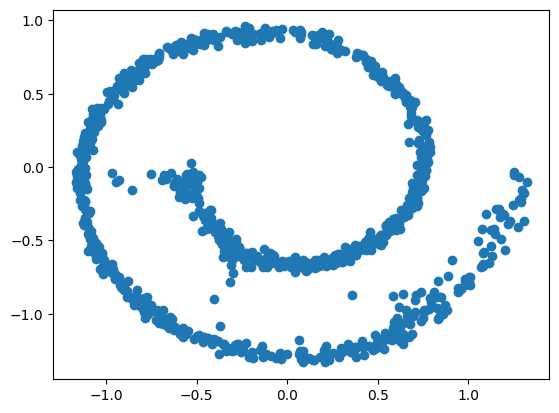

In [10]:
time_steps = 0
plt.scatter(samples[time_steps][:, 0].data.numpy(), samples[time_steps][:, 1].data.numpy());

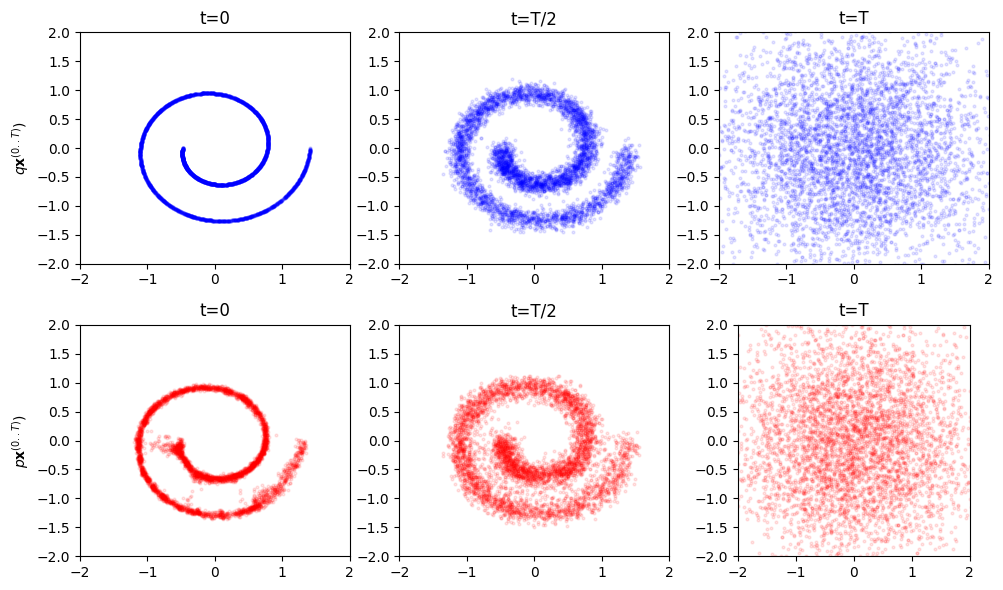

In [11]:
N = 5_000
x0= sample_batch(N)
samples = model.sample(N)

fontsize=22
nrows = 2
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))
# Common x and y limits
x_limits = (-2, 2)
y_limits = (-2, 2)

data = [
        [x0, model.forward_process(x0, 20), model.forward_process(x0, 40)],
        [samples[0], samples[20], samples[40]]
       ]
titles = ['t=0','t=T/2', 't=T']

for i in range(nrows):  # Iterate over rows
    for j in range(ncols):  # Iterate over columns
        colour = "b" if i == 0 else "r"
        if i == 0 and j == 0:
            ax[i,j].set_ylabel(r"$q\mathbf{x}^{(0..T)})$")
        if i == 1 and j == 0:
            ax[i,j].set_ylabel(r"$p\mathbf{x}^{(0..T)})$")
        ax[i,j].scatter(data[i][j][:, 0].data.numpy(), data[i][j][:, 1].data.numpy(), alpha=0.1, c= colour, s=4)
        ax[i,j].set_title(titles[j])
        ax[i,j].set_xlim(x_limits)
        ax[i,j].set_ylim(y_limits)
        plt.gca().set_aspect("equal")

plt.tight_layout()
plt.savefig("diffusion_model_paper1_fig1.png", bbox_inches="tight")